

# A Statistical Framework For Trading Cryptocurrencies  

## [Rasheed Sabar](https://www.linkedin.com/in/rasheedsabar/), October 2017
---

# 1. Introduction 

In this notebook, we build a statistical framework for trading cryptocurrencies.  The notebook accompanies a non-technical post that is [here](https://medium.com/@rasheedsabar/how-to-trade-crypto-quantitatively-c95ba9f31d38). The post provides context for this notebook and should be read alongside it. 

Previously, I've written a jargon-free primer on cryptocurrencies as well as a balanced assessment of their investment merits.  That article is [here](http://bit.ly/WhatAreCryptocurrencies).

We start this notebook with a few module imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 2. The Dataset

We scrape historical daily open, high, low, close data from [coinmarketcap.com](https://coinmarketcap.com/).  The historical data starts in January 2015.  Close prices are as of midnight GMT (i.e. 7pm or 8pm EST; marked 8pm EST below for convenience).  The dataset consists of the top 150 coins or so by market cap.  Our analysis below restricts to the top 30 coins, but we download a larger historical dataset for convenience.  The script that downloads the data is not included here but is available upon request.  



The downloaded data is saved into a CSV file and is read into a dataframe below.  We sort the dataframe by date and CMCid (which is the coinmarketcap.com identifier) and add an index.

In [2]:
df = pd.read_csv("https://drive.google.com/uc?export=download&id=0ByvO1LOwLyYTUjR0dHpodVhLZ1E")
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by = ['date','CMCid'], inplace=True)
df.index = range(0,len(df))

## 2.1 Summary Statistics 

What does the dataset look like?

In [3]:
df.head()

,date,ticker,CMCid,open,high,low,close,volume,marketcap
0,2015-01-01 20:00:00,BAY,bitbay,0.000184,0.000201,0.000180,0.000201,612.0,1.840420e+05
1,2015-01-01 20:00:00,BTC,bitcoin,320.440000,320.440000,314.000000,314.250000,8036550.0,4.380820e+09
2,2015-01-01 20:00:00,BTCD,bitcoindark,1.290000,1.340000,1.160000,1.200000,2933.0,1.548390e+06
3,2015-01-01 20:00:00,BTS,bitshares,0.016329,0.016612,0.016039,0.016331,116338.0,4.078970e+07
4,2015-01-01 20:00:00,BCN,bytecoin-bcn,0.000009,0.000010,0.000008,0.000008,2403.0,1.553670e+06


How many tickers are in our data set over time?

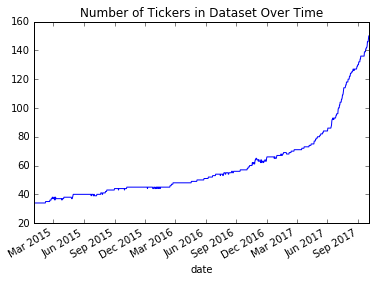

In [4]:
df.groupby('date')['ticker'].count().plot(title="Number of Tickers in Dataset Over Time")

## 2.2 Visualization

Let's plot some price histories from the data, starting with Bitcoin

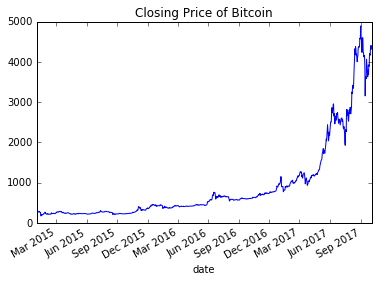

In [5]:
dfBTC = df[df['CMCid']=='bitcoin']
dfBTC.set_index("date",inplace=True)
dfBTC['close'].plot(x=dfBTC.index,title="Closing Price of Bitcoin")

Let's plot Ethereum as well

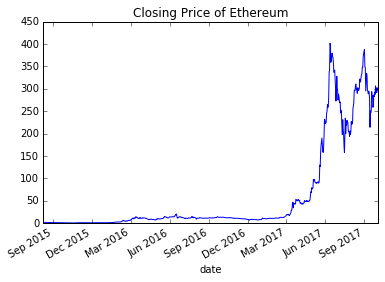

In [6]:
dfETH = df[df['CMCid']=='ethereum']
dfETH.set_index("date",inplace=True)
dfETH['close'].plot(x=dfETH.index,title="Closing Price of Ethereum")

## 3. Append Features to Dataset

We are now going to add columns to our dataframe. 

In particular, we are going to add returns for the previous day and the next day.  Column names and definitions are below:
* **ret**: the daily return (percent change in close price) from the close of the previous day to the close of date
* **retNext**: the daily return from the close of date to close of the next day

We are also going to add our main factors of interest.  This are the momentum, size, and volatility of the asset as defined below:
* **momentum30**: the trailing 30 day average return
* **volatility30**: the trailing 30 day standard deviation of daily returns
* **avglogMC7**: this is our size variable, and is the average of log market capitalization over the past week

We also add a column **wlsW**, which is an inverse variance column ($\frac{1}{\sigma^2}$).  This is not used now but will be useful later for our regressions.

Finally, we drop the open, high, and low columns as they are not used in this analysis.

The columns above are added to a new dataframe labeled df1.

In [7]:
def add_aux_features(frame):
    frame['closeYest'] = frame.close.shift(1)
    frame['ret'] = (frame.close - frame.closeYest) / frame.closeYest

    frame['closeNext'] = frame.close.shift(-1)
    frame['dateNext'] = frame.date.shift(-1)
    frame['retNext'] = (frame.closeNext - frame.close) / frame.close

    frame['avgmarketcap7'] = frame.marketcap.rolling(window=7).mean()

    frame['logMC'] = np.log(frame.marketcap)
    frame['avglogMC7'] = frame.logMC.rolling(window=7).mean()
    frame['momentum30'] = frame.ret.rolling(window=30).mean()
    frame['volatility30'] = frame.ret.rolling(window=30).std()

    frame['wlsW'] = (frame['volatility30'].clip(.02)).pow(-2)
    frame.drop(['open','high','low'],axis=1,inplace=True)
    return frame

In [8]:
df1 = df.groupby('CMCid').apply(add_aux_features)

Let's check out what df1 looks like, restricting it a particular asset.  Note that the date manipulation works.

In [9]:
df1[(df1['CMCid'] == 'bitcoin') & (df1['date'] >= '2017-01-01')].head()

,date,ticker,CMCid,close,volume,marketcap,closeYest,ret,closeNext,dateNext,retNext,avgmarketcap7,logMC,avglogMC7,momentum30,volatility30,wlsW
34498,2017-01-01 20:00:00,BTC,bitcoin,998.33,147775000.0,1.549120e+10,963.74,0.035891,1021.75,2017-01-02 20:00:00,0.023459,1.517910e+10,23.463538,23.442692,0.008537,0.019915,2500.000000
34565,2017-01-02 20:00:00,BTC,bitcoin,1021.75,222185000.0,1.605510e+10,998.33,0.023459,1043.84,2017-01-03 20:00:00,0.021620,1.541443e+10,23.499292,23.458157,0.009610,0.019820,2500.000000
34632,2017-01-03 20:00:00,BTC,bitcoin,1043.84,185168000.0,1.642660e+10,1021.75,0.021620,1154.73,2017-01-04 20:00:00,0.106233,1.567633e+10,23.522168,23.475062,0.010213,0.019903,2500.000000
34699,2017-01-04 20:00:00,BTC,bitcoin,1154.73,344946000.0,1.679540e+10,1043.84,0.106233,1013.38,2017-01-05 20:00:00,-0.122410,1.592989e+10,23.544371,23.491018,0.014407,0.025792,1503.273974
34766,2017-01-05 20:00:00,BTC,bitcoin,1013.38,510199000.0,1.860400e+10,1154.73,-0.122410,902.20,2017-01-06 20:00:00,-0.109712,1.634903e+10,23.646642,23.515536,0.010084,0.035911,775.430512


In [10]:
df1.columns

Index([u'date', u'ticker', u'CMCid', u'close', u'volume', u'marketcap',
       u'closeYest', u'ret', u'closeNext', u'dateNext', u'retNext',
       u'avgmarketcap7', u'logMC', u'avglogMC7', u'momentum30',
       u'volatility30', u'wlsW'],
      dtype='object')

## 3.1 Adding Ranks 

We're going to rank assets by marketcap on each date.  We're also going to add a helper beginning-of-month column.  We will use the marketcap rank at the beginning of each month to define our universe of assets to be modeled. 

In [11]:
df1['marketcapRank'] = df1.groupby('date').avgmarketcap7.rank(ascending=0)
df1['month'] = pd.to_datetime(df1['date'].dt.strftime("%Y-%m"))

def add_BOM(frame):
    frame['marketcapRankBOM'] = frame['marketcapRank'].iloc[0]
    return frame
df2 = df1.groupby(['CMCid', 'month']).apply(add_BOM)

Let's see what df2 looks like for a random date in the middle of a month.  

In [12]:
df2[df2['date'] == '2017-02-15 20:00:00'].head()

,date,ticker,CMCid,close,volume,marketcap,closeYest,ret,closeNext,dateNext,retNext,avgmarketcap7,logMC,avglogMC7,momentum30,volatility30,wlsW,marketcapRank,month,marketcapRankBOM
37561,2017-02-15 20:00:00,AEON,aeon,0.126444,5337.0,1.811460e+06,0.133222,-0.050877,0.128392,2017-02-16 20:00:00,0.015406,2.103371e+06,14.409644,14.551987,0.007153,0.096643,107.067616,48.0,2017-02-01,46.0
37562,2017-02-15 20:00:00,ARDR,ardor,0.017398,96265.0,1.803380e+07,0.018022,-0.034624,0.016174,2017-02-16 20:00:00,-0.070353,1.900701e+07,16.707758,16.759426,0.012755,0.065187,235.330571,19.0,2017-02-01,19.0
37563,2017-02-15 20:00:00,REP,augur,4.850000,282551.0,5.242760e+07,4.760000,0.018908,4.950000,2017-02-16 20:00:00,0.020619,4.879231e+07,17.774944,17.702274,0.007129,0.037996,692.660118,10.0,2017-02-01,9.0
37564,2017-02-15 20:00:00,BAY,bitbay,0.001703,17609.0,1.692660e+06,0.001688,0.008886,0.001813,2017-02-16 20:00:00,0.064592,1.745230e+06,14.341812,14.371657,0.022843,0.094737,111.418509,50.0,2017-02-01,47.0
37565,2017-02-15 20:00:00,BTC,bitcoin,1007.480000,89759400.0,1.626410e+10,1004.550000,0.002917,1027.440000,2017-02-16 20:00:00,0.019812,1.627224e+10,23.512226,23.512449,0.006748,0.026313,1444.347352,1.0,2017-02-01,1.0


Rank and beginning-of-month helper columns look good.

## 3.2 Adding Estimation Universe

Here we are defining the set of assets that we will model.  In particular, the rules for inclusion into our universe are:

* We restrict to the top 30 assets by market cap
* We exclude Tether
* We exclude any asset with a market cap below $15 million

The model is run from the beginning of 2017 onwards.

The estimationUniverse column is appended to df2.

In [13]:
est_condition = (df2['date'] >= '2017-01-01') & (df2['date'] < '2017-10-03') & (df2['marketcapRankBOM'] <= 30) \
                                & (df2['marketcap'] >= 15000000) & (df2['CMCid'] != 'tether')

df2['estimationUniverse'] = 1*est_condition

## 3.3 Standardizing the factors

Here we calculate cross-sectional z-scores for the factors.  That is, each day, we standardize the factors across the universe by subtracting that day's mean factor value and dividing by that day's factor value standard deviation.  Z-scores are winsorized at -5 and +5 standard deviations.

The dataframe df3 restricts df2 to the estimationUniverse, and df4 appends the factor z-score columns:

* **zMomentum**: the z-score of the momentum30 variable
* **zSize**: the z-score of the average log market cap variable
* **zVolatility**: the z-score of the volatility30 variable.

NOTE: for the Size variable above, we use log market cap instead of raw market cap because the latter is extremely skewed.  The log transformation clusters the market caps closer together which is convenient for factor analysis. 

In [14]:
def calc_zFactors(frame):
    frame['zMomentum'] = ((frame['momentum30'] - frame['momentum30'].mean()) \
                          /frame['momentum30'].std()).clip(-5,5)
    frame['zSize'] = -1*((frame['avglogMC7'] - frame['avglogMC7'].mean()) \
                         /frame['avglogMC7'].std()).clip(-5,5)
    frame['zVolatility'] = -1*((frame['volatility30'] - frame['volatility30'].mean()) \
                               /frame['volatility30'].std()).clip(-5,5)
    frame['constant'] = 1
    return frame

df3 = df2[df2['estimationUniverse'] == 1]
df4 = df3.groupby('date').apply(calc_zFactors)

Let's examine our universe on a random date, sorted by market cap descending.

In [15]:
df4[df4['date'] == '2017-09-15 20:00:00'].sort_values(by='marketcap',ascending=False)

,date,ticker,CMCid,close,volume,marketcap,closeYest,ret,closeNext,dateNext,...,volatility30,wlsW,marketcapRank,month,marketcapRankBOM,estimationUniverse,zMomentum,zSize,zVolatility,constant
57406,2017-09-15 20:00:00,BTC,bitcoin,3637.520000,4.148070e+09,5.245350e+10,3154.950000,0.152956,3625.040000,2017-09-16 20:00:00,...,0.056450,313.812433,1.0,2017-09-01,1.0,1,-0.304705,-2.839305,1.964388,1
57437,2017-09-15 20:00:00,ETH,ethereum,250.460000,1.935700e+09,2.036490e+10,213.910000,0.170866,246.520000,2017-09-16 20:00:00,...,0.071644,194.821863,2.0,2017-09-01,2.0,1,-0.243774,-2.233045,1.336490,1
57491,2017-09-15 20:00:00,XRP,ripple,0.181358,2.894140e+08,6.328090e+09,0.164167,0.104717,0.179082,2017-09-16 20:00:00,...,0.087810,129.692152,4.0,2017-09-01,4.0,1,0.490410,-1.426234,0.668444,1
57407,2017-09-15 20:00:00,BCH,bitcoin-cash,424.020000,7.072310e+08,6.126800e+09,367.040000,0.155242,440.220000,2017-09-16 20:00:00,...,0.163760,37.289213,3.0,2017-09-01,3.0,1,1.469797,-1.480003,-2.470216,1
57459,2017-09-15 20:00:00,LTC,litecoin,48.210000,1.554340e+09,2.206520e+09,41.580000,0.159452,48.260000,2017-09-16 20:00:00,...,0.107992,85.747373,5.0,2017-09-01,5.0,1,0.572062,-0.839939,-0.165566,1
57424,2017-09-15 20:00:00,DASH,dash,284.360000,7.269550e+07,1.784040e+09,236.240000,0.203691,298.860000,2017-09-16 20:00:00,...,0.101691,96.702032,6.0,2017-09-01,6.0,1,0.740928,-0.625919,0.094806,1
57475,2017-09-15 20:00:00,XEM,nem,0.211752,1.323180e+07,1.480350e+09,0.164254,0.289174,0.207831,2017-09-16 20:00:00,...,0.094351,112.331968,7.0,2017-09-01,7.0,1,-0.146325,-0.575241,0.398113,1
57469,2017-09-15 20:00:00,XMR,monero,99.850000,1.761540e+08,1.253940e+09,83.040000,0.202433,95.290000,2017-09-16 20:00:00,...,0.137303,53.044201,8.0,2017-09-01,9.0,1,2.108382,-0.396828,-1.376882,1
57455,2017-09-15 20:00:00,MIOTA,iota,0.480510,4.198310e+07,1.238840e+09,0.445019,0.079752,0.487239,2017-09-16 20:00:00,...,0.104392,91.762232,9.0,2017-09-01,8.0,1,-1.324700,-0.330921,-0.016824,1
57438,2017-09-15 20:00:00,ETC,ethereum-classic,10.240000,4.349210e+08,8.684710e+08,9.130000,0.121577,9.930000,2017-09-16 20:00:00,...,0.111790,80.019612,10.0,2017-09-01,11.0,1,-0.298793,-0.238753,-0.322527,1


Looks good.  There are 29 assets in our universe on 2017-09-15, and the ordering by market cap is correct.  The factor z-scores are interesting.  We'll now construct strategies to measure factor efficacy.

# 4. Defining Strategies To Bet on Factors

We first calculate the PNL of a strategy that whose positions are equal to zMomentum, the Momentum Z-scores.  Because zMomentum has zero mean, the strategy is long-short balanced.

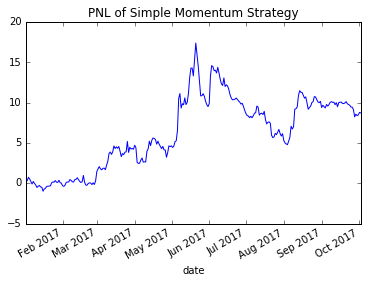

In [16]:
df4['momPnl'] = df4['zMomentum']*df4['retNext']
dailyPnlSimpleMom = df4.groupby('date')['momPnl'].sum()
dailyPnlSimpleMom.cumsum().plot(title="PNL of Simple Momentum Strategy")

Let's calculate the Sharpe Ratio of this strategy

In [17]:
dailyPnlSimpleMom.mean()/dailyPnlSimpleMom.std()*np.sqrt(365)

0.92928192310090219

The simple momentum strategy is not bad.

## 4.1 A Purer Bet on Momentum

As mentioned in the companion [post](https://medium.com/@rasheedsabar/how-to-trade-crypto-quantitatively-c95ba9f31d38), the simple momentum strategy does not do a great job of isolating the momentum effect. 

To see how the each factor performs *while controlling for the effect of the other factors*, we run daily cross-sectional regressions.  

The return-generating model **for each day** is

\begin{equation}
r_{i} = \alpha + \sum_{k=1}^{3}Z_{i,k}\cdot f_{k} + \epsilon_{i}
\end{equation}


The subscript $i$ indexes assets and the subscript $k$ indexes factors.  The equation states that asset returns on a given day are explained by the three factor returns on that day $f_{k}$ (corresponding to momentum, size, and volatility), the assets exposures to those factors $Z_{i,k}$, an intercept term $\alpha$, and an erorr term $\epsilon_{i}$.  For a given asset $i$, the $Z_{i,k}$ are the asset's Z-scores for the 3 factors.

The factor performance $f_{k}$ isolates the effect of that factor while controlling for the other factors.

To estimate the $f_{k}$, we run cross-sectional regressions below.  In particular, we use WLS regressions with a weight matrix $W$ whose diagonal entries are the inverse variance of the assets (the **wlsW** feature defined previously).  This forces the regression to put more weight on fitting assets with lower volatility, and ensures that the factor return estimates are robust to extremely high volaitlity assets. 

In [18]:
def factor_return_names(factorList):
    return ['fr_%s'%el for el in factorList]

def run_factor_regressions(frame,factorList):
    #Only consider rows with necessary data for the subset of columns we care about
    df1 = frame.dropna(axis=0,subset=['retNext'] + factorList + ['wlsW']) 
    X = df1[factorList]

    result = sm.WLS(df1['retNext'], X.astype(float), weights=df1['wlsW']).fit()

    frame['residual'] = frame['retNext'] - (frame[factorList]*result.params).sum(axis=1,skipna=False)
    para = pd.DataFrame(result.params).T
    para['date'] = pd.to_datetime(df1['date'].iloc[0])
    para.columns = factor_return_names(factorList) + ['date']

    dfMerged = frame.merge(para,how='left',on='date')
    return dfMerged

In [19]:
import statsmodels.api as sm
factorList = ['constant','zMomentum','zSize','zVolatility']
df5 = df4.groupby('date').apply(run_factor_regressions,factorList)

Let's examine df5.  Note the extra columns **fr_zMomentum**, **fr_zSize**, **fr_zVolatilty** which are the factor returns $f_{k}$, the outputs of the regression.

In [20]:
df5.head()

date ticker     CMCid       close  \
date                                                                     
2017-01-01 20:00:00 0 2017-01-01 20:00:00    REP     augur    4.000000   
                    1 2017-01-01 20:00:00    BTC   bitcoin  998.330000   
                    2 2017-01-01 20:00:00   DASH      dash   11.230000   
                    3 2017-01-01 20:00:00    DGD  digixdao    9.040000   
                    4 2017-01-01 20:00:00   DOGE  dogecoin    0.000228   

                            volume     marketcap   closeYest       ret  \
date                                                                     
2017-01-01 20:00:00 0     230517.0  4.126690e+07    3.770000  0.061008   
                    1  147775000.0  1.549120e+10  963.740000  0.035891   
                    2    3684210.0  7.835060e+07   11.210000  0.001784   
                    3       8349.0  1.707200e+07    8.540000  0.058548   
                    4     136829.0  2.402600e+07    0.000223  0.022422   

                         closeNext            dateNext       ...        \
date                                                         ...         
2017-01-01 20:00:00 0     4.190000 2017-01-02 20:00:00       ...         
                    1  1021.750000 2017-01-02 20:00:00       ...         
                    2    11.810000 2017-01-02 20:00:00       ...         
                    3     8.710000 2017-01-02 20:00:00       ...         
                    4     0.000226 2017-01-02 20:00:00       ...         

                       zMomentum     zSize  zVolatility  constant    momPnl  \
date                                                                          
2017-01-01 20:00:00 0   0.019634  0.372770    -0.306748         1  0.000933   
                    1   0.030055 -3.123684     1.221718         1  0.000705   
                    2   0.099046 -0.015994     0.874116         1  0.005115   
                    3  -0.192391  0.824117     0.172955         1  0.007023   
                    4  -0.692733  0.612615     1.264787         1  0.006077   

                       residual  fr_constant  fr_zMomentum  fr_zSize  \
date                                                                   
2017-01-01 20:00:00 0  0.026042     0.021323       0.02577 -0.003532   
                    1 -0.005907     0.021323       0.02577 -0.003532   
                    2  0.030409     0.021323       0.02577 -0.003532   
                    3 -0.049426     0.021323       0.02577 -0.003532   
                    4 -0.006182     0.021323       0.02577 -0.003532   

                       fr_zVolatility  
date                                   
2017-01-01 20:00:00 0       -0.003082  
                    1       -0.003082  
                    2       -0.003082  
                    3       -0.003082  
                    4       -0.003082  

[5 rows x 31 columns]

## 4.2 Plotting The Factor Returns

We plot the cumulative factor returns $f_{k}$ over time.  These constitute a bet on the corresponding factor which is orthogonal to the other factors.

In [21]:
def restrict_to_factor_returns(frame,factorList):
    return frame[['dateNext'] + factor_return_names(factorList)][:1]

factorReturns = df5.groupby('date').apply(restrict_to_factor_returns,factorList)
factorReturns.set_index(["dateNext"],inplace=True)
factorReturns.index.names = ['date']

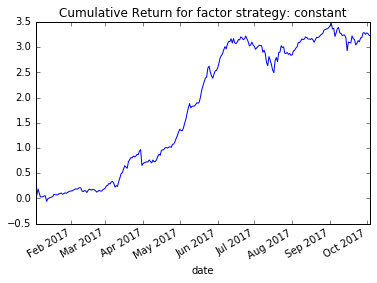

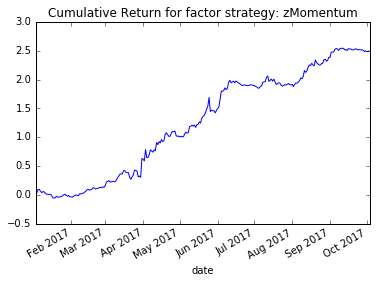

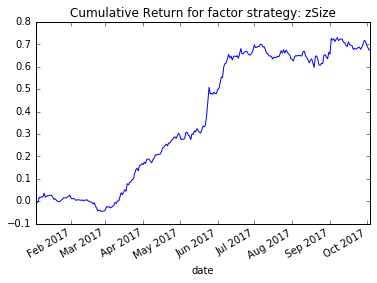

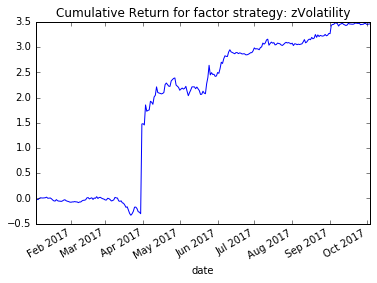

In [22]:
factorNames = factor_return_names(factorList)
for factorName,factor in zip(factorNames,factorList):
    factorReturns.cumsum()[factorName].plot(title="Cumulative Return for factor strategy: %s"%factor)
    plt.show()

Side Note: The performance of the "Constant" strategy above is good because the space has gone up.  It represents a diversified long-only portfolio.  The factor strategies are long-short portfolios and so do not appreciate due to the space having gone up.

Now, compare the performance of the Momentum Factor Strategy above to the Simple Momentum Strategy previously.  The latter strategy had a pre-cost Sharpe Ratio of 0.93.  The pre-cost Sharpe Ratio of the former is much higher, at 3.8

In [23]:
factorReturns['fr_zMomentum'].mean()/factorReturns['fr_zMomentum'].std()*np.sqrt(365)

3.8215285999632891

## 4.3 Calculating Factor Scores

We can reproduce the regression results by calculating daily **factor scores** starting from factor Z-scores.  These are like factor Z-scores but control for the effect of the other factors, and will allow us to reproduce the regression results directly.

Since we are running WLS regressions, the formula for F = $(f_1,f_2,f_3)$ on a given day is

\begin{equation*}
F = \left(Z^{T}\cdot W \cdot Z \right)^{-1}\cdot X^{T}\cdot W,
\end{equation*}

where $Z$ is the matrix of Z-scores and $W$ is the diagonal weight matrix with inverse variance diagonal entries.

We implement this calculation below.

In [24]:
def calculate_factorScores(df):
    df1 = df[['CMCid']+factorList+['wlsW'] + ['retNext']].dropna()
    df1.set_index(['CMCid'],inplace=True)

    X = df1[factorList].as_matrix()
    W = np.diag(df1['wlsW'])
    f = np.dot(np.dot(np.linalg.inv(np.dot(np.dot(X.transpose(),W),X)),X.transpose()),W).transpose()

    fdf = pd.DataFrame(f, index = df1.index)
    fdf.columns = factorList
    fdf['retNext'] = df1['retNext']
    fdf['date'] = df.date.iloc[0]

    return fdf

In [25]:
factorWeights = df5.groupby('date').apply(calculate_factorScores)

Now we calculate the Factor Momentum strategy, which is a strategy whose positions are proportional to the Momentum factor scores.

In [26]:
factorWeights['momPnl'] = factorWeights['zMomentum']*factorWeights['retNext']

Let's visualize this strategy's PNL.

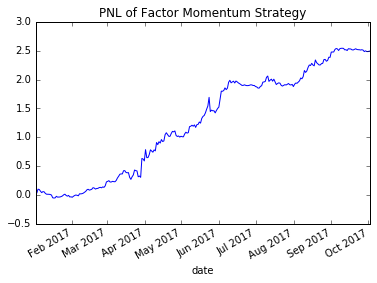

In [27]:
factorMomentumStrategyPNL = factorWeights.groupby('date')['momPnl'].sum()
factorMomentumStrategyPNL.cumsum().plot(title="PNL of Factor Momentum Strategy")

Let's calculate the Sharpe of this strateggy to make sure it matches our regression-based calculation

In [28]:
factorMomentumStrategyPNL.mean()/factorMomentumStrategyPNL.std()*np.sqrt(365)

3.8215285999632922

It Matches.

# Conclusion

We have two sets of factor scores.  The first set are factor Z-scores, and the second set are factor scores.  A strategy that bets proportional to the factor Z-scores (our "simple momentum strategy" above) is OK.  A strategy that bets proportional to the factor scores is much more effective.


Let's look at both sets of scores for a particular date, October 2 2017.

First, here are the factor Z-scores, sorted by Momentum Z-scores.

In [29]:
df5[df5['date']=='2017-10-02 20:00:00'][['CMCid']+factorList].dropna().sort_values(by='zMomentum')

CMCid  constant  zMomentum     zSize  \
date                                                                           
2017-10-02 20:00:00 8                     eos         1  -1.764526  0.864129   
                    25                stratis         1  -1.362124  0.489125   
                    24                stellar         1  -1.233977  0.948718   
                    10       ethereum-classic         1  -1.175102 -0.165659   
                    6            bytecoin-bcn         1  -1.168652  0.857256   
                    16           maidsafecoin         1  -0.871384  0.942747   
                    15               litecoin         1  -0.840478 -0.758219   
                    17                 monero         1  -0.694274 -0.305233   
                    4            bitcoin-cash         1  -0.546065 -1.385321   
                    26                   tenx         1  -0.507451  0.796294   
                    1                   augur         1  -0.340258  0.935315   
                    18                    nem         1  -0.139309 -0.564372   
                    11   golem-network-tokens         1  -0.083979  0.948758   
                    9                ethereum         1   0.031024 -2.285398   
                    22                 ripple         1   0.039353 -1.399341   
                    7                    dash         1   0.092002 -0.678852   
                    21                   qtum         1   0.097532  0.273473   
                    14                   lisk         1   0.216990  0.206119   
                    12                   iota         1   0.296688 -0.373176   
                    20                omisego         1   0.387903 -0.050558   
                    3                 bitcoin         1   0.470717 -2.881254   
                    27                  waves         1   0.542046  0.425696   
                    23                  steem         1   0.941335  0.699249   
                    5              bitconnect         1   0.994737  0.030496   
                    28                  zcash         1   1.002799  0.265950   
                    2   basic-attention-token         1   1.283283  0.906318   
                    0                     ark         1   1.725651  0.761981   
                    19                    neo         1   2.605520 -0.334634   

                        zVolatility  
date                                 
2017-10-02 20:00:00 8     -0.858291  
                    25     0.054811  
                    24    -0.143962  
                    10    -0.247841  
                    6      0.366977  
                    16    -0.137673  
                    15    -0.018133  
                    17     0.818167  
                    4      0.192759  
                    26    -1.372094  
                    1      1.092468  
                    18    -0.169399  
                    11    -0.648329  
                    9      0.827181  
                    22     1.957249  
                    7      1.279254  
                    21    -1.722620  
                    14    -0.725198  
                    12    -0.657013  
                    20    -0.583987  
                    3      1.543795  
                    27     0.349006  
                    23    -0.156191  
                    5      1.240921  
                    28     0.274832  
                    2     -0.152130  
                    0      0.266720  
                    19    -2.671279

On October 2, 2017, the simple momentum model likes neo, ark, and the basic-attention-token as those have the highest momentum zScores.

In contrast, the factor scores on the same date are below, also sorted by the Momentum score.

In [30]:
factorWeights[factorWeights['date']=='2017-10-02 20:00:00'].dropna().sort_values(by='zMomentum')

constant  zMomentum     zSize  \
date                CMCid                                                  
2017-10-02 20:00:00 stratis                0.036358  -0.056903  0.013224   
                    bytecoin-bcn           0.036829  -0.054166  0.038352   
                    eos                    0.034579  -0.050943  0.003380   
                    stellar                0.036319  -0.045588  0.023162   
                    ethereum-classic       0.035901  -0.045068 -0.013339   
                    monero                 0.036460  -0.044093  0.007075   
                    litecoin               0.036303  -0.037570 -0.028387   
                    maidsafecoin           0.036577  -0.031136  0.024402   
                    bitcoin-cash           0.036545  -0.030018 -0.047997   
                    augur                  0.036596  -0.017786  0.091061   
                    tenx                   0.033905  -0.010720 -0.002302   
                    ethereum               0.036393  -0.009299 -0.086753   
                    ripple                 0.025801  -0.008299 -0.015192   
                    nem                    0.036623  -0.006750 -0.021192   
                    golem-network-tokens   0.036000   0.000496  0.013981   
                    qtum                   0.033139   0.003212 -0.014232   
                    dash                   0.035387   0.003965  0.009244   
                    lisk                   0.035817   0.008088 -0.005510   
                    iota                   0.035904   0.009288 -0.019279   
                    omisego                0.036204   0.013544 -0.009770   
                    bitcoin                0.032394   0.022742 -0.138051   
                    waves                  0.038142   0.029611  0.027931   
                    steem                  0.037722   0.040666  0.022359   
                    neo                    0.031331   0.044957 -0.023526   
                    zcash                  0.038398   0.050147  0.021066   
                    basic-attention-token  0.038020   0.055118  0.030163   
                    bitconnect             0.037213   0.079862  0.057660   
                    ark                    0.039140   0.086645  0.042470   

                                           zVolatility   retNext  \
date                CMCid                                          
2017-10-02 20:00:00 stratis                  -0.001283 -0.025575   
                    bytecoin-bcn              0.025282 -0.038724   
                    eos                      -0.026465 -0.036250   
                    stellar                  -0.001004 -0.043126   
                    ethereum-classic         -0.026718 -0.002412   
                    monero                    0.027117  0.015512   
                    litecoin                 -0.030930 -0.019296   
                    maidsafecoin             -0.000866  0.026795   
                    bitcoin-cash             -0.037359 -0.040386   
                    augur                     0.098334  0.003614   
                    tenx                     -0.037812 -0.024793   
                    ethereum                 -0.033958 -0.016875   
                    ripple                    0.147019  0.003168   
                    nem                      -0.032012 -0.037595   
                    golem-network-tokens     -0.019537 -0.038811   
                    qtum                     -0.048706  0.020202   
                    dash                      0.061694 -0.040332   
                    lisk                     -0.033545  0.051661   
                    iota                     -0.041323 -0.023785   
                    omisego                  -0.034319  0.004348   
                    bitcoin                  -0.002946 -0.020829   
                    waves                     0.013267 -0.024742   
                    steem                    -0.006636 -0.061069   
                    neo                      -0.060691 -0.0851

For the factor momentum strategy, the top 3 picks on October 2 are ark, bitconnect, and the basic-attention-token.

The two sets of scores have different picks, and different weights on those picks.  The differences add up over time.

Empirically, the second set of scores perform better.  To track these on a go-forward basis, see below.

## Tracking Factor Scores going forward

I'll push daily factor scores on Twitter, [@RasheedSabar](https://twitter.com/RasheedSabar)